In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from IPython import display
from tqdm import tqdm
import numpy as np
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
(train_imgs, train_lbls), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

train_imgs = (train_imgs.reshape(train_imgs.shape[0], 28, 28, 1).astype('float32') - 127.5) / 127.5
test_images = (test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') - 127.5) / 127.5

dataset = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(60000).batch(256)

In [3]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def generator_loss(image):
    return cross_entropy(tf.ones_like(image), image)

In [4]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, generator_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    generator_loss = cross_entropy(tf.zeros_like(generator_output), generator_output)
    return real_loss + generator_loss

def naive_discriminator_loss(real_output, generator_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return real_loss

In [5]:
#Make IS model
# model = tf.keras.Sequential(
#     [
#         tf.keras.Input(shape=(28,28,1)),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(10, activation="softmax"),
#     ]
# )
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.fit(train_images, tf.keras.utils.to_categorical(train_labels, 10), batch_size=256, epochs=15)
# score = model.evaluate(test_images, tf.keras.utils.to_categorical(test_labels, 10), verbose=0)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])
# model.save("ISModel")

In [6]:
def calculate_inception_score(images):
    model = tf.keras.models.load_model('ISModel')
    preds = model.predict(images)
    scores = []
    n_part = int(np.floor(images.shape[0] / 10))
    for i in range(10):
        start, end = i * n_part, i * n_part + n_part
        p_yx = preds[start:end]
        p_y = np.expand_dims(p_yx.mean(axis=0), 0)
        kl_d = p_yx * (np.log(p_yx + 1E-16) - np.log(p_y + 1E-16))
        sum_kl_d = kl_d.sum(axis=1)
        avg_kl_d = np.mean(sum_kl_d)
        scores.append(np.exp(avg_kl_d))
    return np.mean(scores)

def kl_divergence(images):
    model = tf.keras.models.load_model('ISModel')
    preds = model.predict(images)
    p = np.zeros(10)
    for e in preds:
        p[np.argmax(e)] = p[np.argmax(e)] +1
    p = p / np.sum(p)
    q = np.full(10, .1)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))


In [7]:
seed = tf.random.normal([64, 100])
is_avg_array = []
kl_avg_array = []
epochs = 75

def train(dataset):
    for epoch in range(epochs):
        for image_batch in tqdm(dataset, position=0, leave=True):
            train_step(image_batch)
            
        display.clear_output(wait=True)
        analyze_model(generator, seed)

    display.clear_output(wait=True)
    analyze_model(generator, seed)

@tf.function
def train_step(example_images):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_images = generator(tf.random.normal([256, 100]), training=True)
        reals = discriminator(example_images, training=True)
        fakes = discriminator(generated_images, training=True)
        gradients_of_generator = generator_tape.gradient(generator_loss(fakes), generator.trainable_variables)
        gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss(reals, fakes), discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def analyze_model(model, seed):
    random_preds = model(tf.random.normal([500, 100]), training=False)
    seed_predictions = model(seed, training=False)
    
    is_avg = calculate_inception_score(random_preds)
    kl_avg = kl_divergence(random_preds)
    is_avg_array.append(is_avg)
    kl_avg_array.append(kl_avg)

    plt.plot(is_avg_array)
    plt.title("IS vs Epoch")
    plt.ylabel('Inception Score')
    plt.xlabel('Epoch')
    plt.show()
    print("IS: ", is_avg)

    plt.plot(kl_avg_array)
    plt.title("KL vs Epoch")
    plt.ylabel('Kullback-Leibler Divergence')
    plt.xlabel('Epoch')
    plt.show()
    print("KL: ", kl_avg)
    
    fig = plt.figure(figsize=(8, 8))
    for i in range(seed_predictions.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow(seed_predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

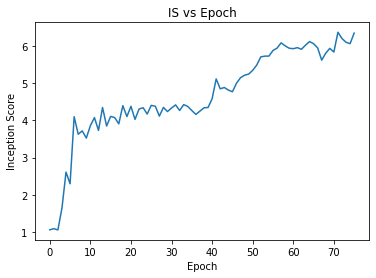

IS:  6.3497343


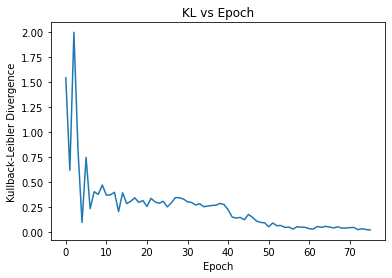

KL:  0.01837594706880943


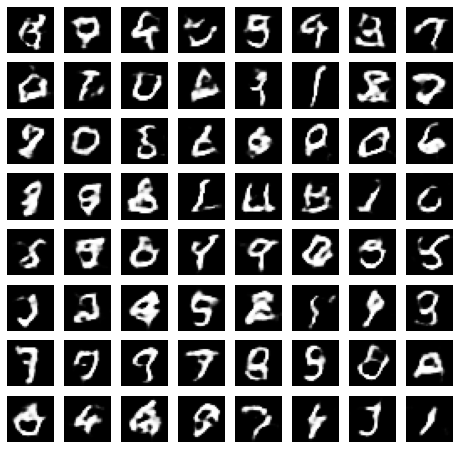

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: SGDMomentum_Generator75\assets
INFO:tensorflow:Assets written to: SGDMomentum_Discriminator75\assets


In [8]:
generator = generator()
discriminator = discriminator()
generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)
discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)
train(dataset)
generator.save('SGDMomentum_Generator75')
discriminator.save('SGDMomentum_Discriminator75')

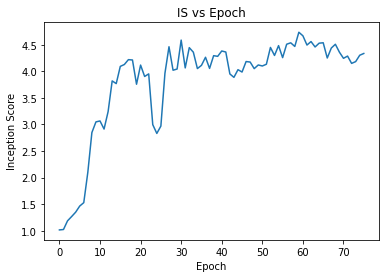

IS:  4.334178


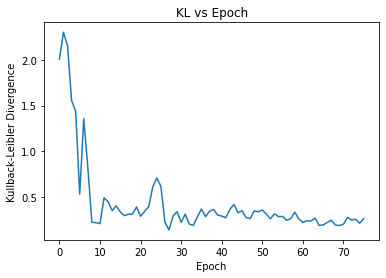

KL:  0.2613768666870715


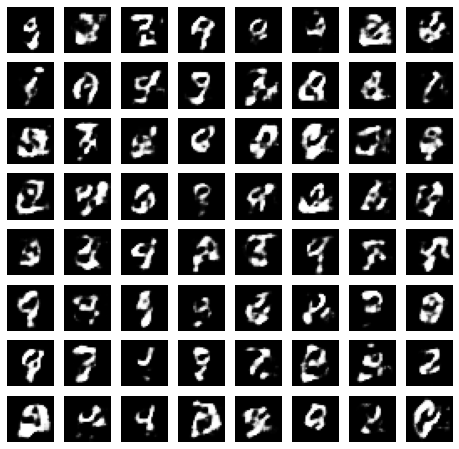

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: SGD_Generator75\assets
INFO:tensorflow:Assets written to: SGD_Discriminator75\assets


In [8]:
generator = generator()
discriminator = discriminator()

generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0)
discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0)
train(dataset)
generator.save('SGD_Generator75')
discriminator.save('SGD_Discriminator75')

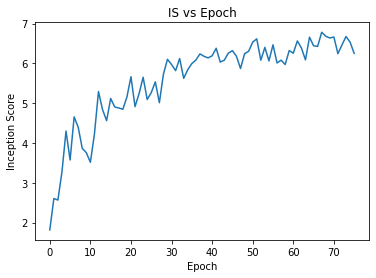

IS:  6.250848


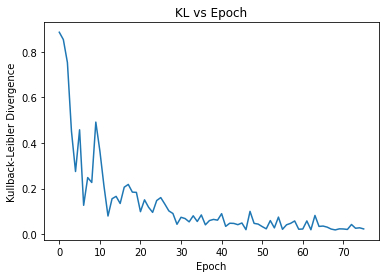

KL:  0.022984694832890683


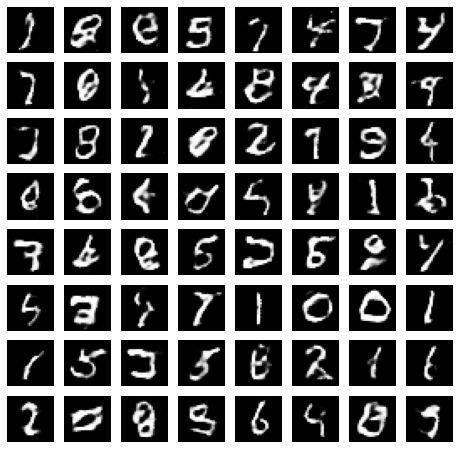

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Adam_Generator75\assets
INFO:tensorflow:Assets written to: Adam_Discriminator75\assets


In [8]:
generator = generator()
discriminator = discriminator()

generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()
train(train_dataset)
generator.save('Adam_Generator75')
discriminator.save('Adam_Discriminator75')

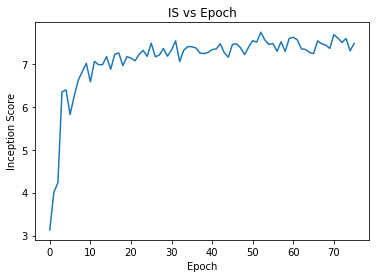

IS:  7.475953


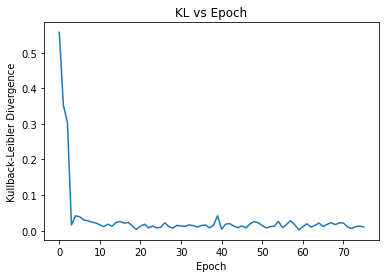

KL:  0.010630332452722109


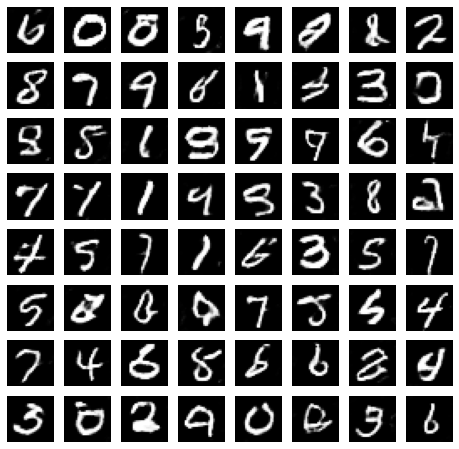

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: RMSprop_Generator75\assets
INFO:tensorflow:Assets written to: RMSprop_Discriminator75\assets


In [8]:
generator = generator()
discriminator = discriminator()

generator_optimizer = tf.keras.optimizers.RMSprop()
discriminator_optimizer = tf.keras.optimizers.RMSprop()
train(train_dataset)
generator.save('RMSprop_Generator75')
discriminator.save('RMSprop_Discriminator75')